In [2]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import randrange
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time

#% matplotlib inline

In [3]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [4]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p)
        if collFree == False: return False

    return collFree

In [5]:
def draw_map(obstacles):
    # Obstacles. An obstacle is represented as a convex hull of a number of points.
    # First row is x, second is y (position of vertices)

    # Bounds on world
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )

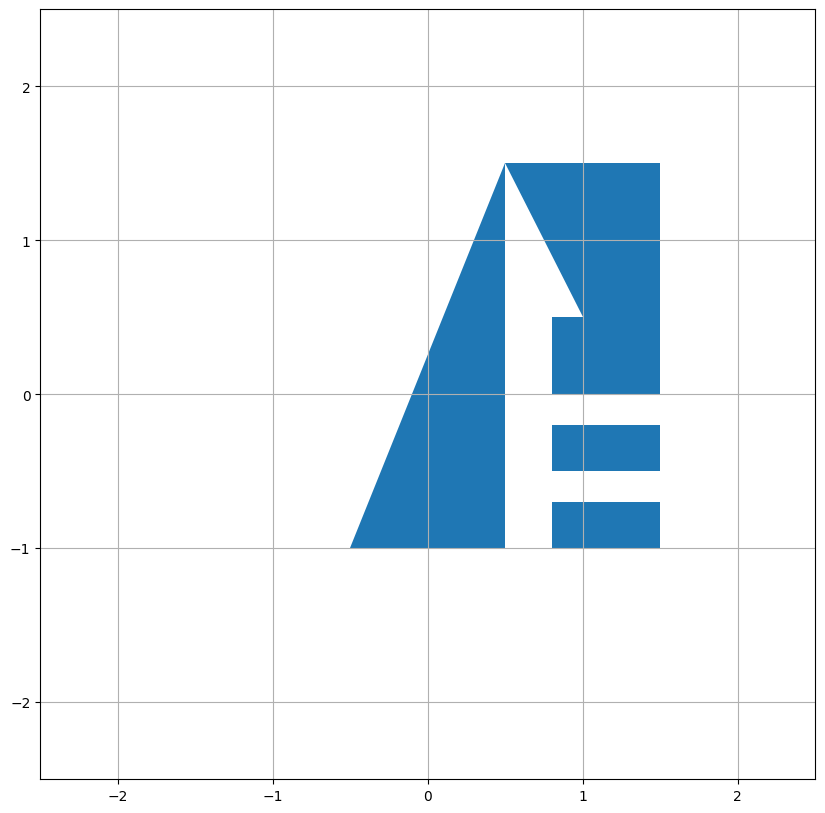

In [92]:
w = 0.5
obstacles = [
              np.array([[1, -0.5], [1, -0.5], [1, -0.5], [2, w-1]]),
              #np.array([[1, -1], [w, -1.8], [0.1, 1], [-0.5, -1]]),
              #np.array([[0, 1-w], [2, 1.5], [1, 0.5+w], [0, 0.5+w]]),
              np.array([[0-w, -1], [0+w, -1], [0.5, 1.5]]),
              np.array([[1-w, 1+w], [1+w, 1+w], [1+w, 0.5], [1, 0.5]]),
              np.array([[0.8, 0], [1+w, 0], [1+w, w], [0.8, w]]),
              np.array([[0.8, -0.5], [1+w, -0.5], [1+w, 0.3-w], [0.8, 0.3-w]]),
              np.array([[0.8, -0.7], [1+w, -0.7], [1+w, -0.5-w], [0.8, -0.5-w]])

              #np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              #np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]
draw_map(obstacles)

In [93]:
class Node:
    def __init__(self):
        self.p     = [0,0]#[randrange(-2, 2,0.5), randrange(-2, 2,0.5)]
        self.i     = 0
        self.iPrev = 0

In [94]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [95]:
def SmoothPath(P, obstacles, smoothiters=10):
    # INPUTS
    #   P - path to get smoothed (after RRT algorithm)
    #   obstacles - says where the obstacles are
    #   smoothiters - maximum number of smoothing iterations
    #
    # OUTPUTS
    #   P_smoothed - a path, same format as before:
    #    P_smoothed = [q1 q2 q3 ... qM]
    #               where q1=qstart and qM=qgoal; in other words, the sequence
    #               of straight-line paths from q1 to q2, q2 to q3, etc., takes
    #               the robot from start to goal without collision
    m = P.shape[0]
    l = np.zeros(m)
    for k in range(1, m):
        l[k] = norm(P[k,:]-P[k-1,:]) + l[k-1] # find all of the straight-line distances
    iters = 0
    while iters < smoothiters:
        s1 = random()*l[m-1]
        s2 = random()*l[m-1]
        if s2 < s1:
            temps = s1
            s1 = s2
            s2 = temps
        for k in range(1, m):
            if s1 < l[k]:
                i = k - 1
                break
        for k in range(i, m):
            if s2 < l[k]:
                j = k - 1
                break
        if (j <= i):
            iters = iters + 1
            continue
        t1 = (s1 - l[i]) / (l[i+1]-l[i])
        gamma1 = (1 - t1)*P[i,:] + t1*P[i+1,:]
        t2 = (s2 - l[j]) / (l[j+1]-l[j])
        gamma2 = (1 - t2)*P[j,:] + t2*P[j+1,:]

        collisionFree = isCollisionFreeEdge(obstacles, gamma1, gamma2)
        if collisionFree == 0:
            iters = iters + 1
            continue
#         print round(l[i],2), round(s1,2), round(l[i+1],2)
#         plt.plot(P[i,0], P[i,1], 'ro', markersize=10, color='red')
#         plt.plot(gamma1[0], gamma1[1], 'ro', markersize=10, color='green')
#         plt.plot(P[i+1,0], P[i+1,1], 'ro', markersize=10, color='blue')
#         plt.plot(P[j,0], P[j,1], 'ro', markersize=10, color='red')
#         plt.plot(gamma2[0], gamma2[1], 'ro', markersize=10, color='green')
#         plt.plot(P[j+1,0], P[j+1,1], 'ro', markersize=10, color='blue')
#         plt.plot([gamma1[0], gamma2[0]], [gamma1[1], gamma2[1]], color='k', linewidth=5)

#         print round(l[j],2), round(s2,2), round(l[j+1],2)
        P = np.vstack([P[:(i+1),:], gamma1, gamma2, P[(j+1):m,:]])
        m = P.shape[0]
        l = np.zeros(m)
        for k in range(1, m):
            l[k] = norm( P[k,:] - P[k-1,:] ) + l[k-1]
        iters = iters + 1
#         plt.plot(P[:,0], P[:,1], '--', linewidth=3)
    P_smooth = P

    return P_smooth

C:\Users\krasa\AppData\Local\Temp\ipykernel_4456\2909347353.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  xy_start = np.array([1.6, -1.1]); plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
C:\Users\krasa\AppData\Local\Temp\ipykernel_4456\2909347353.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  xy_goal =  np.array([0.6, 1]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize=20)
C:\Users\krasa\AppData\Local\Temp\ipykernel_4456\2909347353.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES


Number of iterations passed: 5000 / 5000
RRT length:  4157
Constructing the path...
Reached RRT start node
Path smoothing...
Reached the goal after 0.14 seconds:
Number of iterations passed: 109 / 5000
RRT length:  85
Constructing the path...
Reached RRT start node
Path smoothing...
Number of iterations passed: 5000 / 5000
RRT length:  4193
Constructing the path...
Reached RRT start node
Path smoothing...
Number of iterations passed: 5000 / 5000
RRT length:  4160
Constructing the path...
Reached RRT start node
Path smoothing...
Reached the goal after 11.75 seconds:
Number of iterations passed: 4701 / 5000
RRT length:  3886
Constructing the path...
Reached RRT start node
Path smoothing...
Reached the goal after 9.71 seconds:
Number of iterations passed: 4317 / 5000
RRT length:  3642
Constructing the path...
Reached RRT start node
Path smoothing...
Reached the goal after 0.05 seconds:
Number of iterations passed: 35 / 5000
RRT length:  24
Constructing the path...
Reached RRT start node
P

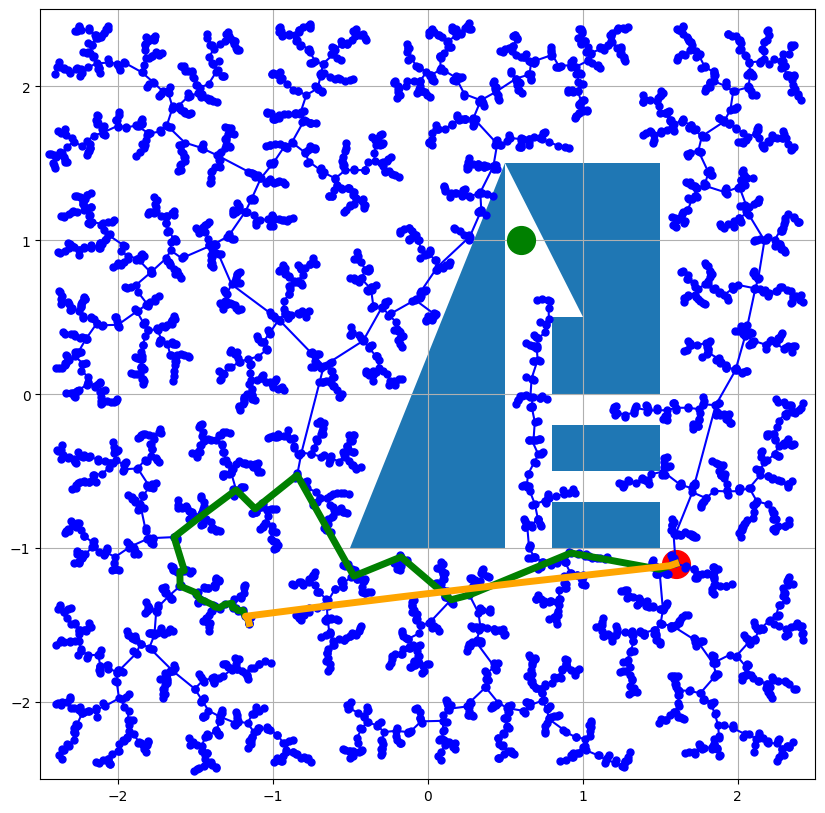

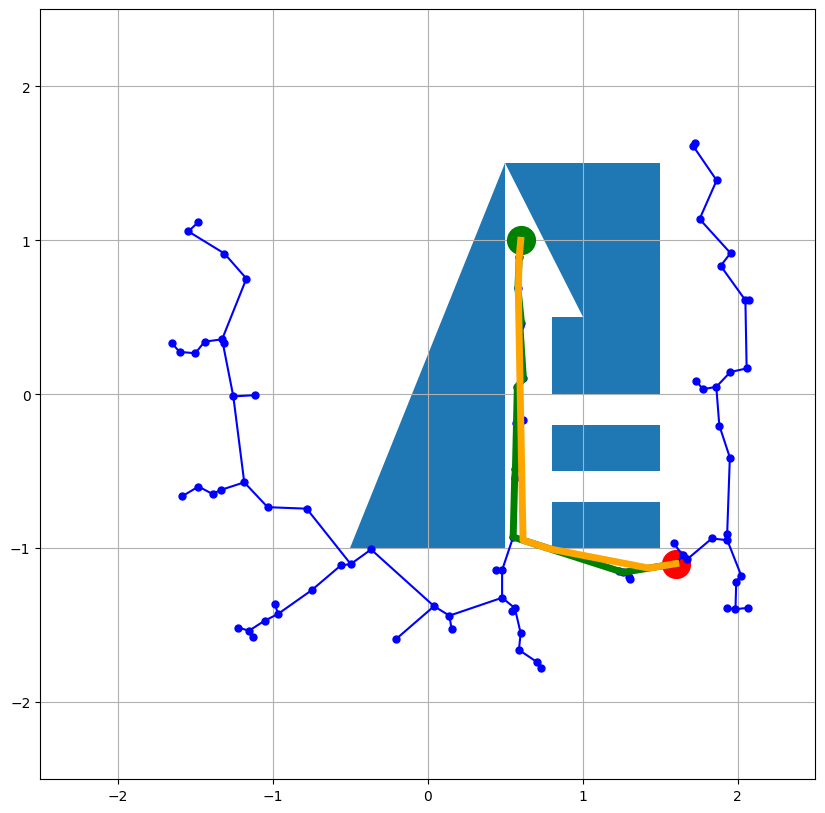

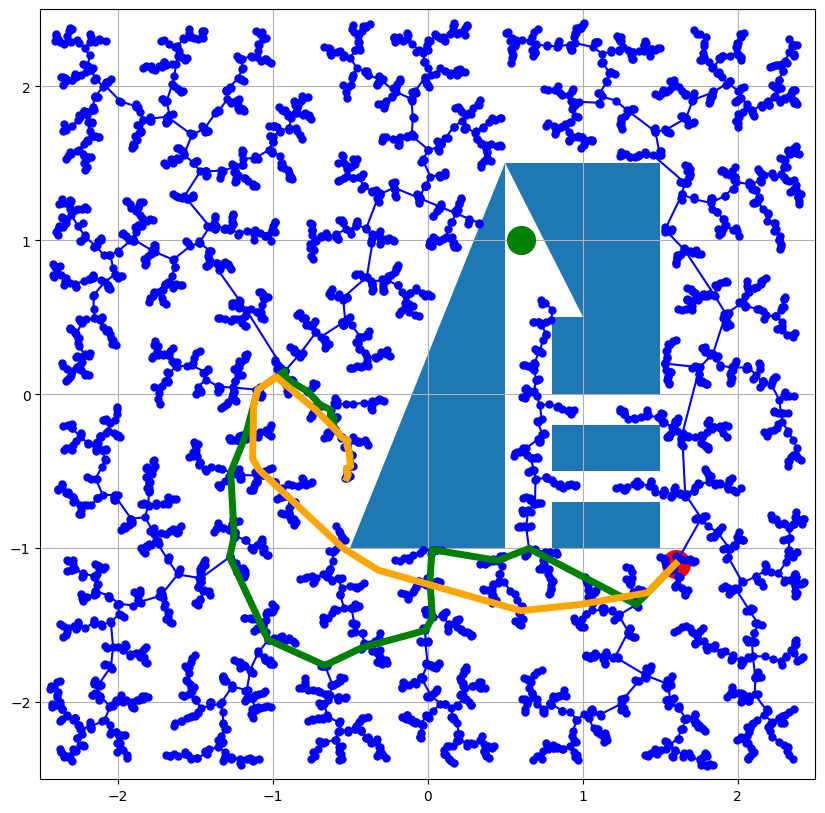

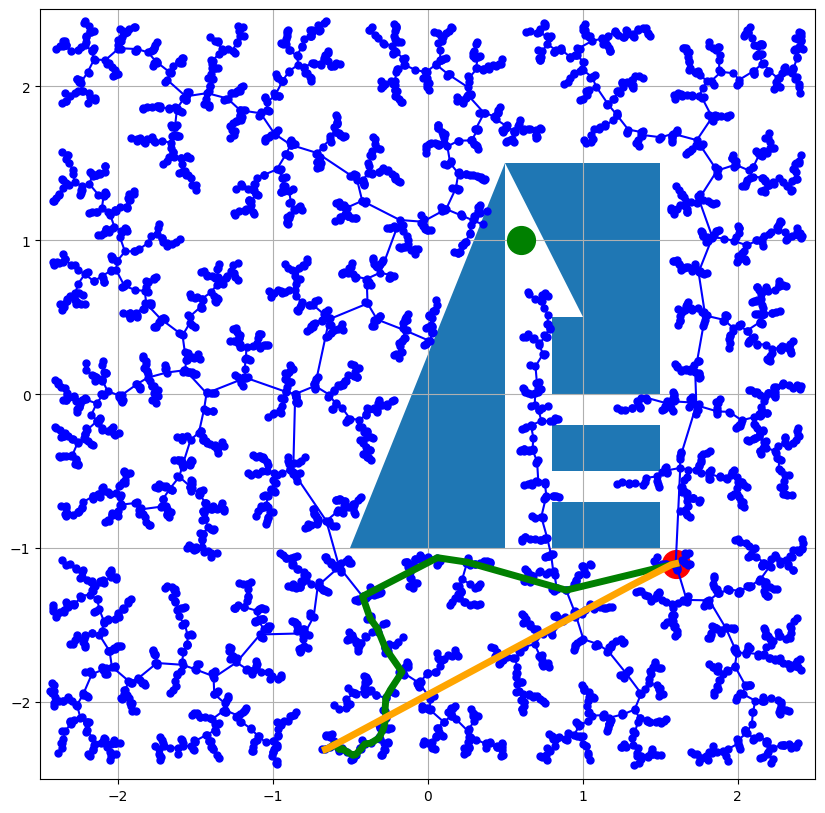

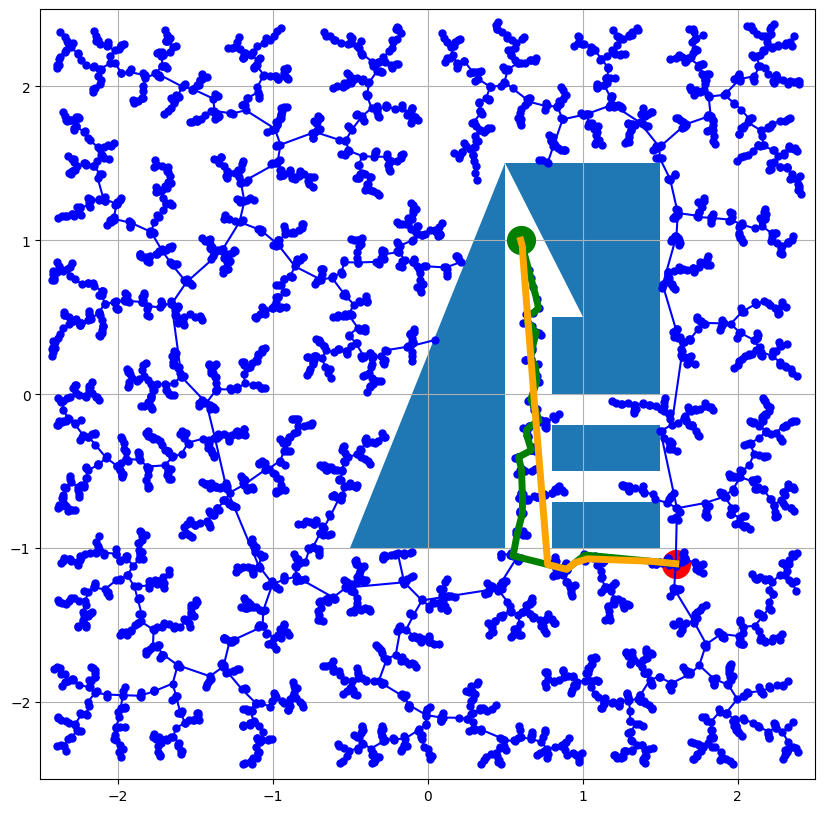

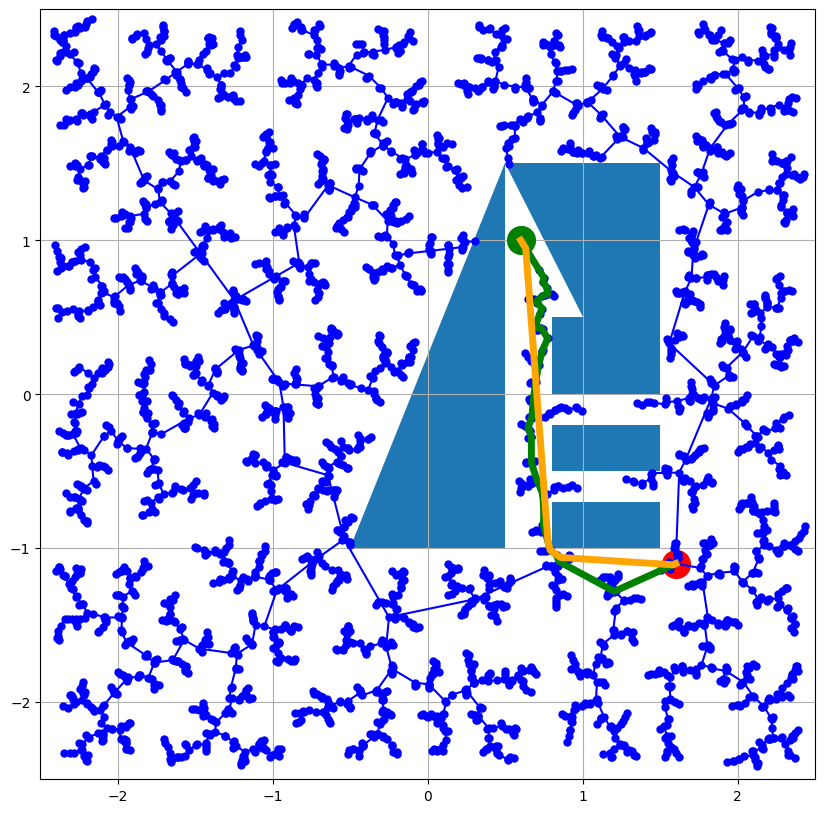

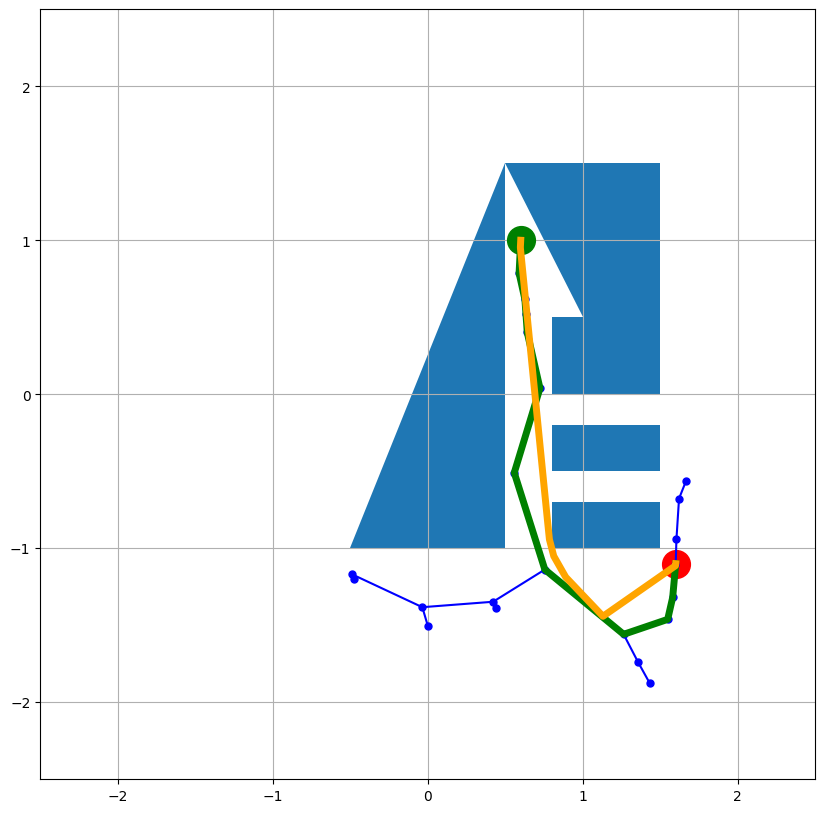

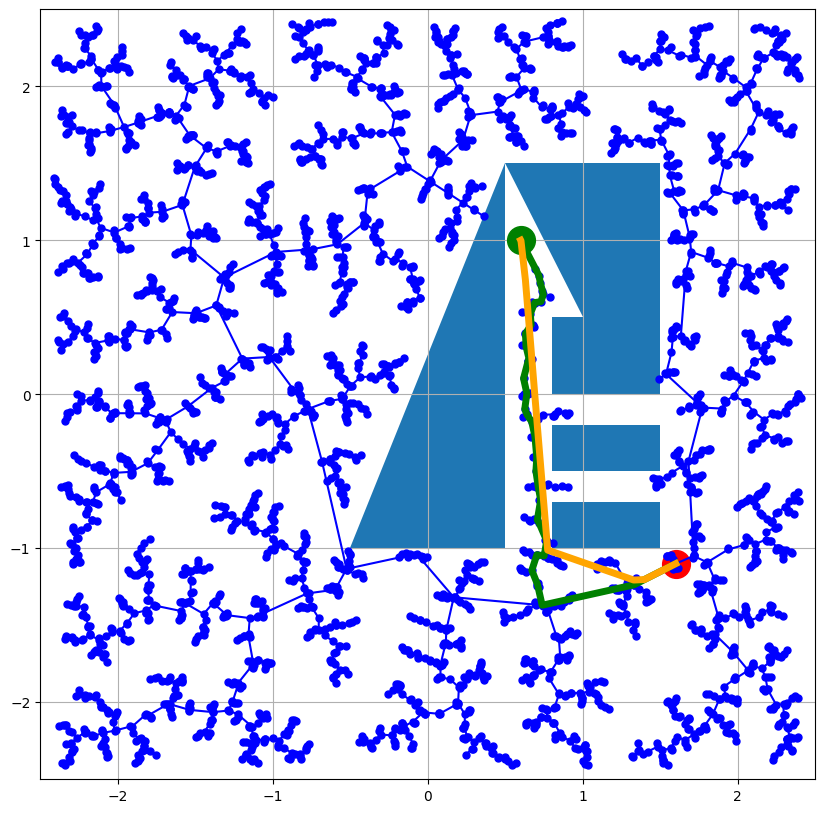

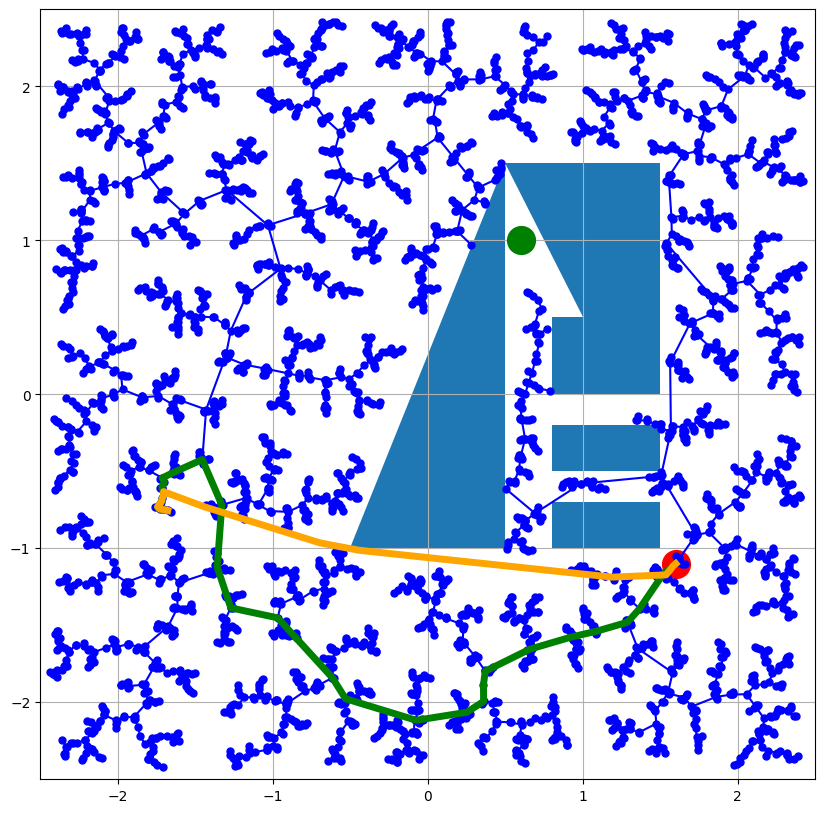

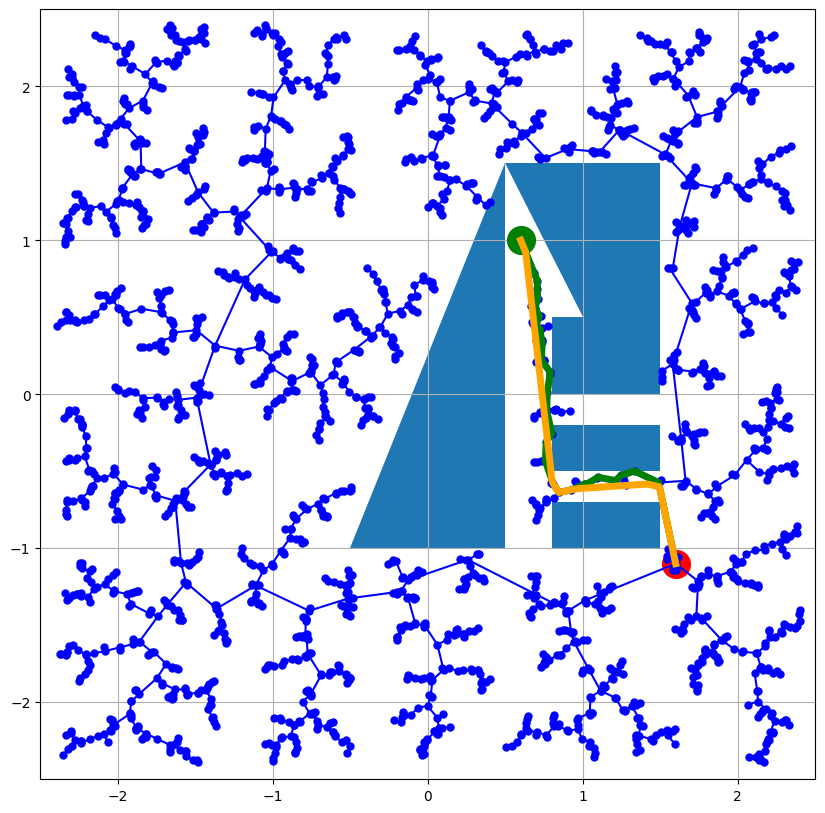

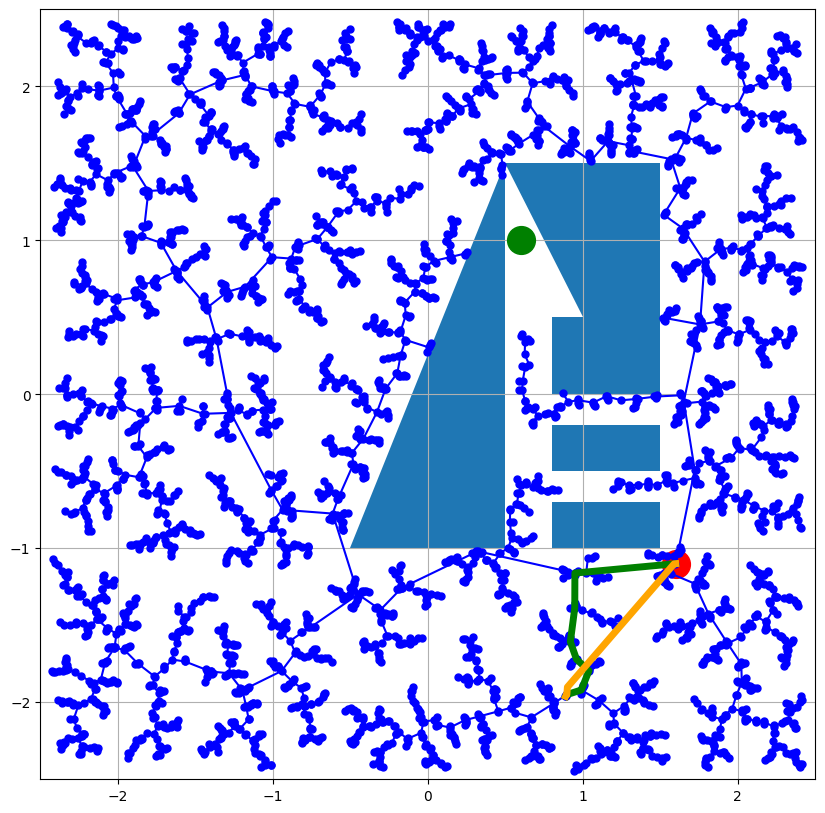

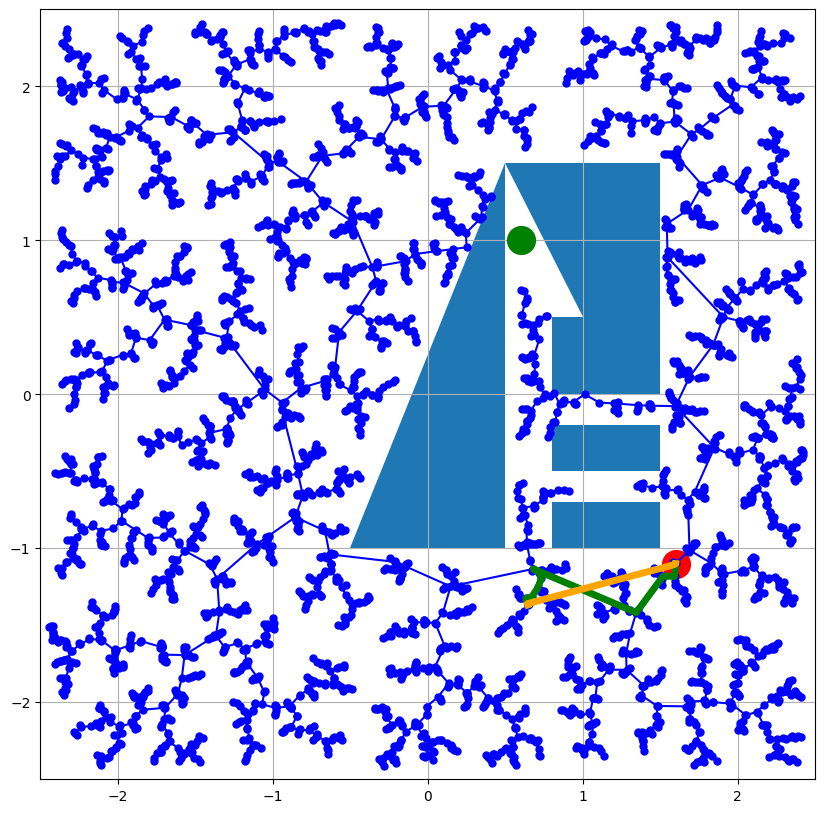

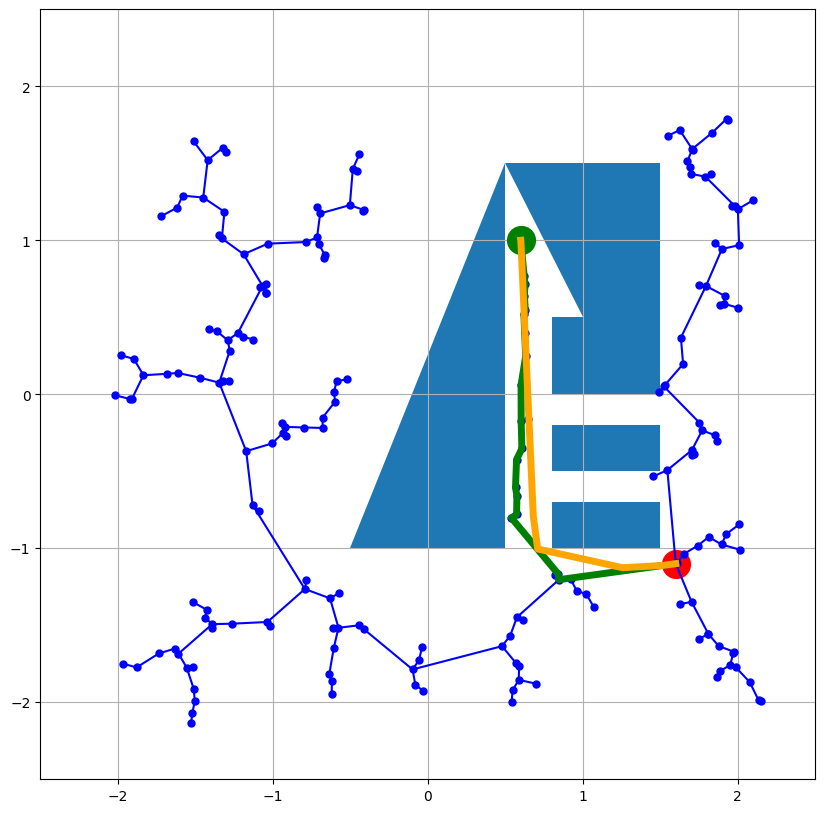

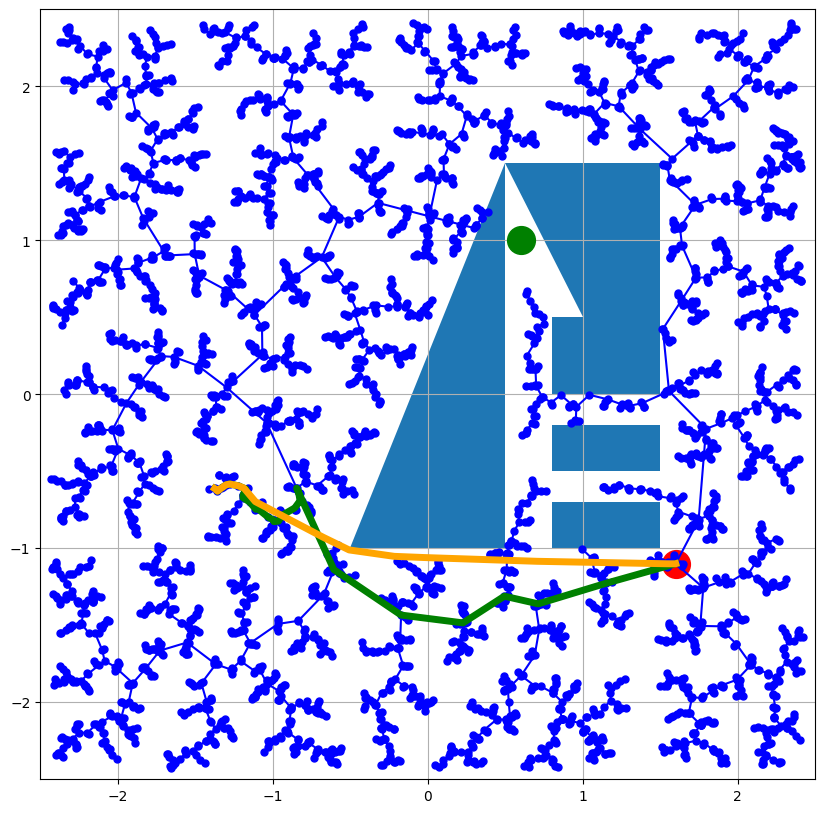

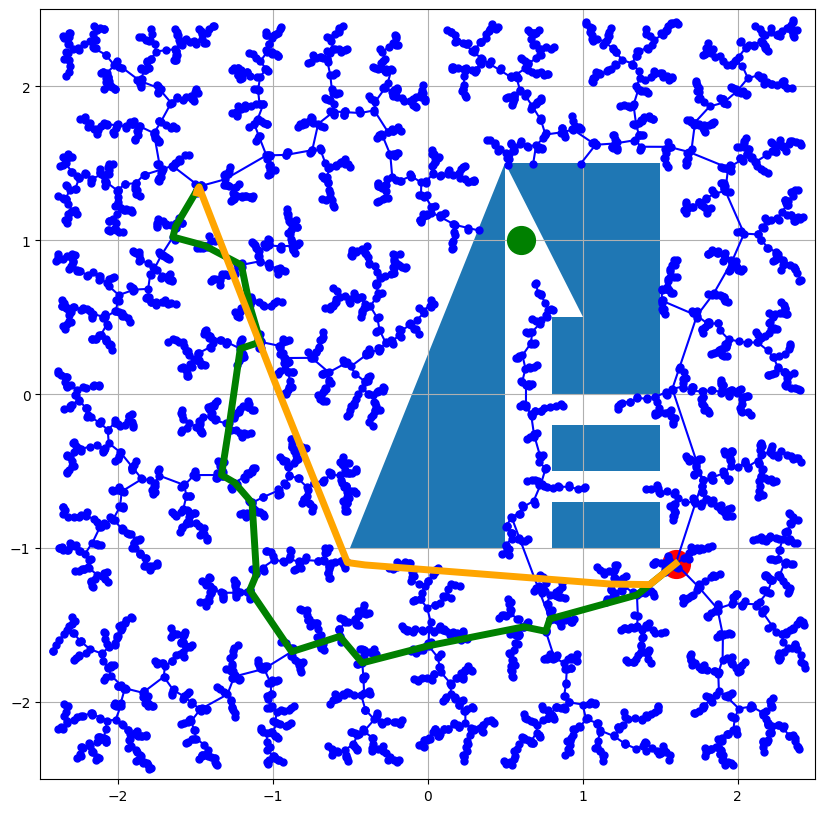

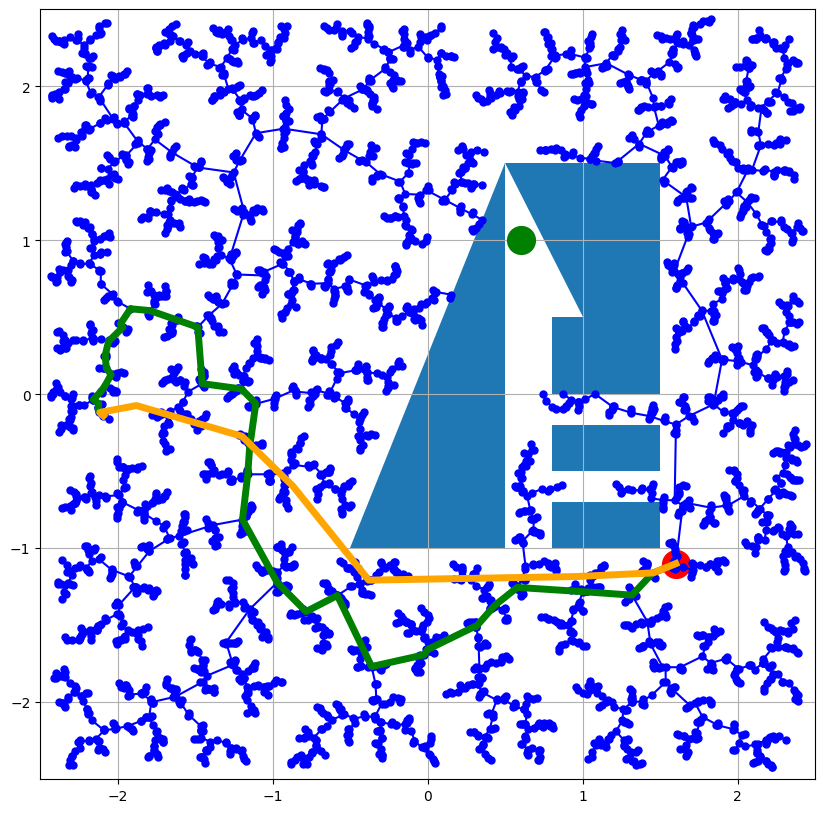

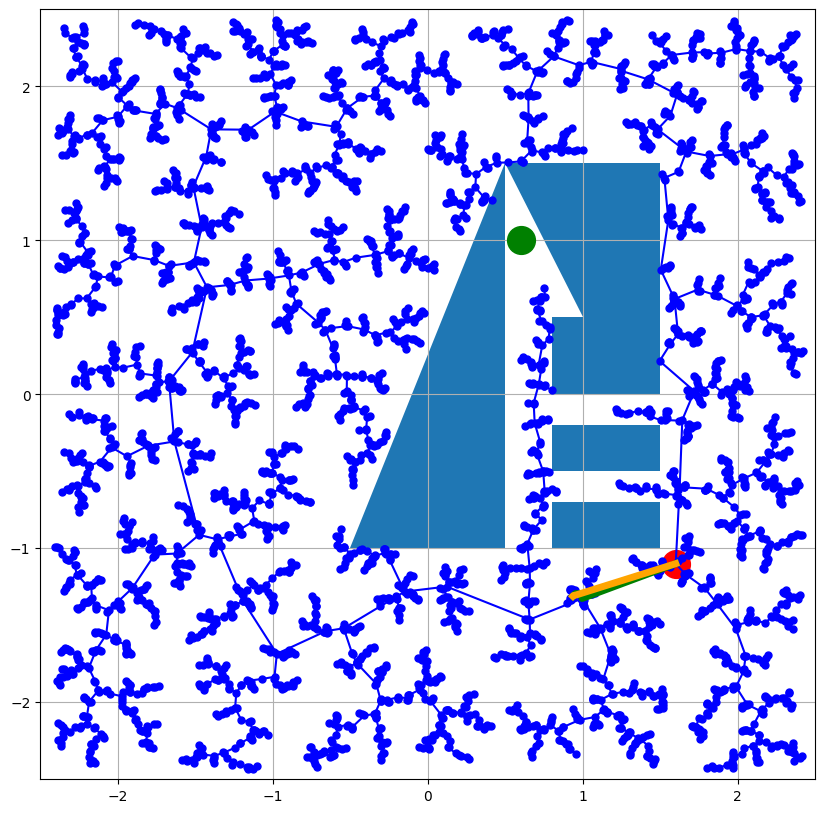

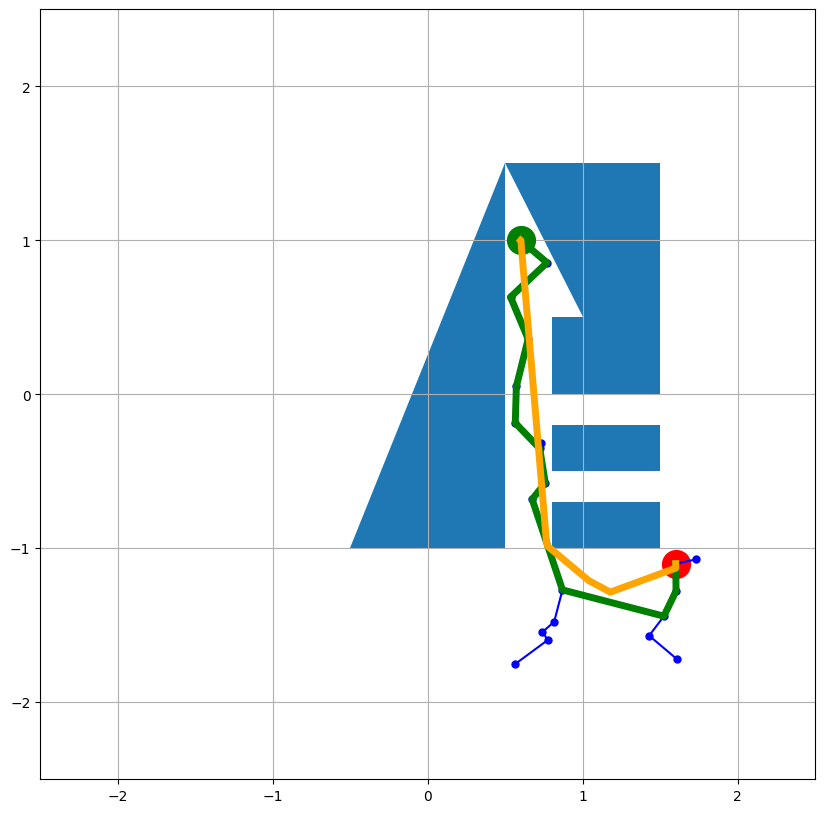

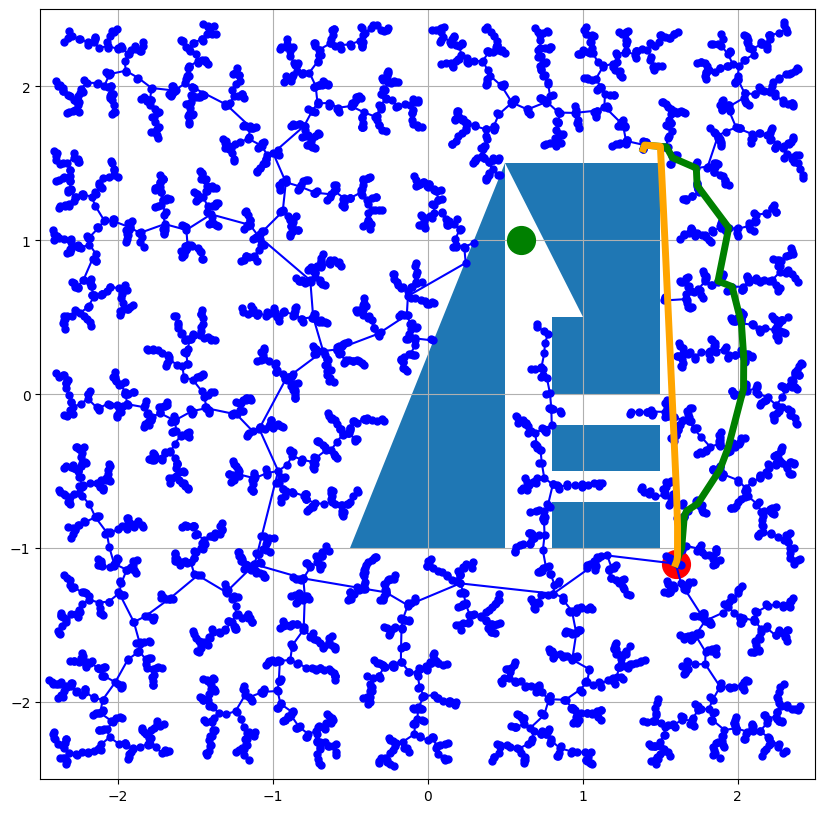

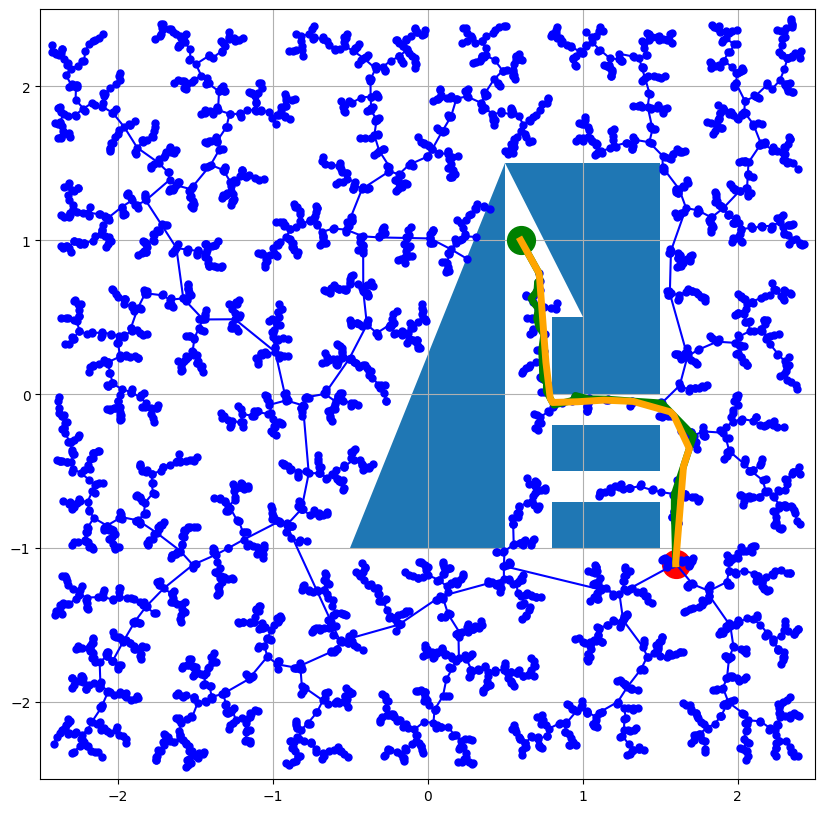

In [114]:
for f in range(20):
    P=[]
    # Initialization
    visualize = 5000
    maxiters  = 5000
    nearGoal = False # This will be set to true if goal has been reached
    minDistGoal = 0.25 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
    d = 0.20 # Extension parameter: this controls how far the RRT extends in each step.

    draw_map(obstacles)

    # Start and goal positions
    xy_start = np.array([1.6, -1.1]); plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize=20)
    xy_goal =  np.array([0.6, 1]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize=20)

    # Initialize RRT. The RRT will be represented as a 2 x N list of points.
    # So each column represents a vertex of the tree.
    rrt = []
    start_node = Node()
    start_node.p = xy_start
    start_node.i = 0
    start_node.iPrev = 0
    rrt.append(start_node)


    # RRT algorithm
    start_time = time.time()
    iters = 0
    while not nearGoal and iters < maxiters:
        # Sample point
        rnd = random()
        # With probability 0.05, sample the goal. This promotes movement to the goal.
        if rnd < 0.05:
            xy = xy_goal
        else:
            # Sample (uniformly) from space (with probability 0.95). The space is defined
            # with the bounds world_bounds_x and world_bounds_y defined above.
            # So, the x coordinate should be sampled in the interval
            # world_bounds_x=2.5 and the y coordinate from world_bounds_y=2.5.
            xy = np.array([random()*5-2.5, random()*5-2.5]) # Should be a 2 x 1 vector
        # Check if sample is collision free
        collFree = isCollisionFreeVertex(obstacles, xy)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

        # If it is collision free, find closest point in existing tree.
        closest_node = closestNode(rrt, xy)

        # Extend tree towards xy from closest_vert. Use the extension parameter
        # d defined above as your step size. In other words, the Euclidean
        # distance between new_vert and closest_vert should be d.
        new_node = Node()
        new_node.p = closest_node.p + d * (xy - closest_node.p)
        new_node.i = len(rrt)
        new_node.iPrev = closest_node.i

        # Check if new vertice is in collision
        collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
        # If it's not collision free, continue with loop
        if not collFree:
            iters += 1
            continue

            # If it is collision free, add it to tree
        rrt.append(new_node)

        if visualize:
            # plt.plot(xy[0], xy[1], 'ro', color='k')
            plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5) # VERTICES
            plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color='blue') # EDGES

        # Check if we have reached the goal
        if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
            # Add last, goal node
            goal_node = Node()
            goal_node.p = xy_goal
            goal_node.i = len(rrt)
            goal_node.iPrev = new_node.i
            if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
                rrt.append(goal_node)
                P = [goal_node.p]
            else: P = []
            end_time = time.time()
            nearGoal = True
            print('Reached the goal after %.2f seconds:' % (end_time - start_time))

        iters += 1

    print('Number of iterations passed: %d / %d' % (iters, maxiters))
    print('RRT length: ', len(rrt))

    # Path construction from RRT:
    print('Constructing the path...')
    i = len(rrt) - 1
    while True:
        i = rrt[i].iPrev
        P.append(rrt[i].p)
        if i == 0:
            print('Reached RRT start node')
            break
    P = np.array(P)
    plt.plot( P[:,0], P[:,1], color='green', linewidth=5, label='RRT path' )

    # Path smoothing:
    print('Path smoothing...')
    P_smooth = SmoothPath(P, obstacles, smoothiters=40)
    plt.plot(P_smooth[:,0], P_smooth[:,1], linewidth=5, color='orange', label='smoothed path')

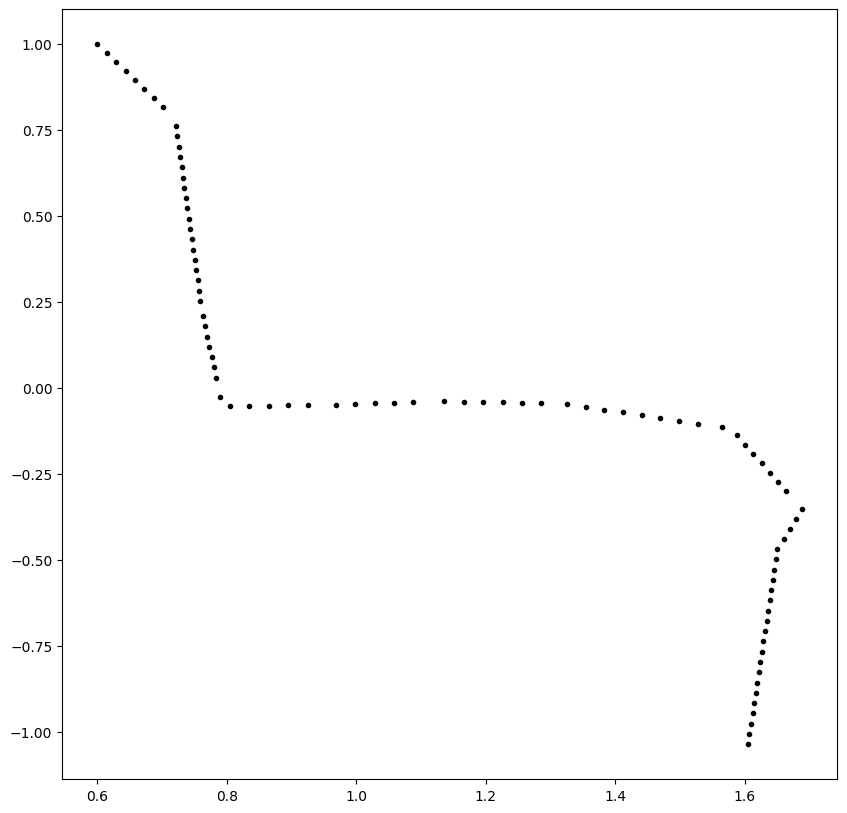

In [115]:
V = 0.3
rate = 10; dt = 1./rate
dx = V * dt

traj = np.array([P_smooth[0]])
plt.figure(figsize=(10,10))
for i in range(len(P_smooth)-1):
    A = P_smooth[i]
    B = P_smooth[i+1]
    traj = np.vstack([traj, A])

    n = (B-A) / norm(B-A)
    delta = n * dx
    N = int( norm(B-A) / norm(delta) )
    sp = A
    for i in range(N):
        plt.plot(sp[0], sp[1], '.', color='k')
        sp += delta
        traj = np.vstack([traj, sp])